# Backwards Generated Data

Until now I have used the model to infere the bias of graders and the true score of a handin.
In this note book I will use the model and its distributions to generate observed data and see if the model can infere the same distributions.
The generated observed data will be in the continues range [0,1].

Later I will try to apply some "noise" by generate observed data and "discretize" the data into the bins 
0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1

So the value 0.54 will be set to 0.5 and 8.79 will be set to 0.9.
After applying the noice i will see if the model can still infere the same distributions as the data was generated from

Motivation:
These two task will validate the model to see if the genrated oberseved data makes sense and that the model does it to the scenario

In [1]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot as mcplot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId
import random

In [108]:
g = pm.Gamma('Test',50,0.1)

In [133]:
g.random()

array(544.2863480626268)

# Real data

In order to see if the generated data looks like the real data we can start to plot the origianl data and later the generated data from the model.

In [2]:
client = MongoClient()
db = client.heroku_rnwkcq9r

In [3]:
def question_text(question_id):
    question = db.question.find_one({'_id': question_id})
    return question['text']

def question_max_value(question_id):
    question = db.question.find_one({'_id': question_id})
    if question['question_type'] == "boolean":
        return 1
    elif question["question_type"] == "numerical":
        if 'numericalAnswers' in question:
            max_value = max(map(int,question['numericalAnswers'].keys()))
            return max_value
        else:
            return 3

def answer_value(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    q_id = answer['question']
    if 'numerical_answer' in answer:
        return answer['numerical_answer'] / float(question_max_value(q_id))
    elif 'boolean_answer' in answer:
        return answer['boolean_answer'] / float(question_max_value(q_id))
    
def answer_with_score(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    return 'text_answer' not in answer

def score_handin_grader(handin_id,grader_id):
    # find all answers to the hand in of the grader and average it out
    report_grade = db.report_grade.find_one({'handin': handin_id, 'giver': grader_id})
    answers = db.answer.find({'report_grade': report_grade['_id'] })
    handin_acc = 0.0
    for answer in answers:
        if answer_with_score(answer['_id']):
            handin_acc = handin_acc + answer_value(answer['_id'])
    return handin_acc / float(answers.count())

def score_handin_list(handin_id):
    scores = list()
    report_grades = db.report_grade.find({'handin': handin_id, 'state': 'ANSWERED'})
    for report_grade in report_grades:
        scores.append((score_handin_grader(handin_id,report_grade['giver']),report_grade['giver']))
    return scores

# finds the reported score for each handins in an assignment
# returns a list containing the the id and score of each handin
def assignment_handins(assignment_id):
    handins_reports = list()
    handins = db.handin.find({'assignment': assignment_id})
    for handin in handins:
        handins_reports.append((score_handin_list(handin['_id']),handin['_id']))
    return handins_reports

# finds the reported score for each handins in an assignment
# returns a list containing the id of each handin
def assignment_handins_id(assignment_id):
    handins_reports = list()
    handins = db.handin.find({'assignment': assignment_id})
    for handin in handins:
        handins_reports.append(handin['_id'])
    return handins_reports

def grader_ids(assignment_id):
    graders = set()
    report_grades = db.report_grade.find({'assignment':assignment_id})
    for report_grade in report_grades:
        graders.add(report_grade['giver'])
    return list(graders)

def grader_id(grader_name):
    grader = db.user.find_one({'name': grader_name})
    return grader['_id']

def grader_name(grader_id):
    grader = db.user.find_one({'_id': grader_id})
    return grader['name']

def number_of_reports(user_name, assignment_id):
    user = db.user.find_one({'name': user_name })
    reports = db.report_grade.find({'assignment': assignment_id, 'giver': user['_id'], 'state': 'ANSWERED'})
    return reports.count()

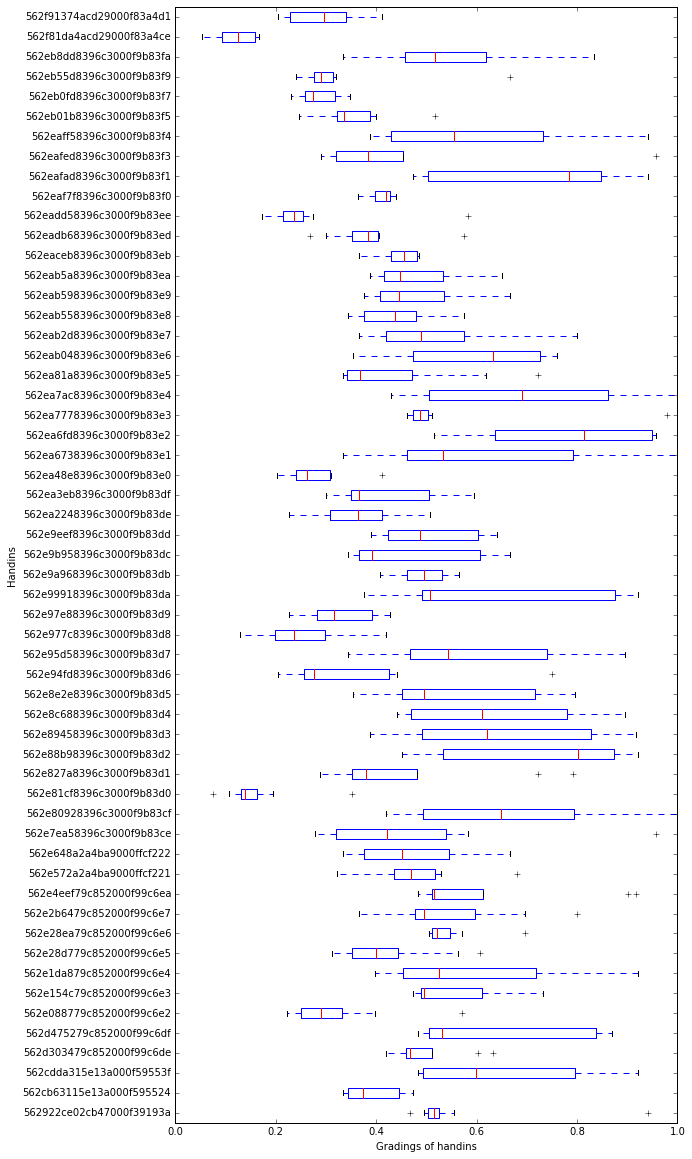

In [4]:
real_data = assignment_handins(ObjectId("55f69a6cb3cbf8000b5ae1c8"))

ax = plt.subplot(111)

values = list()
labels = list()

for scores, handin_id in real_data:
    v = map(lambda x: x[0],scores)
    values.append(v)
    labels.append(handin_id)
    
plt.boxplot(values,0, vert=False, labels=labels)

box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*1.5, box.height*5])
plt.ylabel('Handins')
plt.xlabel('Gradings of handins')
plt.xlim(0,1)
plt.show()


## Data Structure

In [5]:
def random_limit(distribution):
    val = distribution.random()
    while val > 1 or val < 0:
        val = distribution.random()
    return val

In [6]:
class grader(object):
    def __init__(self, name,bias_value):
        self.name = name
        self.handins = list()
        self.bias_value = bias_value
        
    def add_handin(self, handin):
        self.handins.append(handin)
                
    def grade_handins(self):
        for handin in self.handins:
            handin.add_gradeing(self,self.bias_value)

In [7]:
class handin:
    def __init__(self,title,owner,true_value):
        self.title = title
        self.owner = owner
        self.gradeings = dict()
        self.graders = list()
        self.true_val = true_value
    
    def add_grader(self,grader):
        self.graders.append(grader)
    
    def add_gradeing(self,grader,bias):
        obs = pm.Normal('obs_generator',self.true_val+bias,100)
        self.gradeings[grader.name] = random_limit(obs)

In [356]:
class assignment(object):
    
    def __init__(self, handins_input, graders_input):
        self.handins = dict()
        self.graders = dict()
        for handin in handins_input:
            self.handins[handin.title] = handin
        for grader in graders_input:
            self.graders[grader.name] = grader
    
    def add_handin(self, handin):
        self.handing[handin.title] = handin
        
    def add_grader(self, grader):
        self.graders[grader.title] = grader
    
    def find_ungraded_handin(self, grader):
        
        # sort the handins by the one with the least
        sorted_l = sorted(self.handins.values(),key=lambda x: len(x.graders))
        i = int(random.uniform(0,len(sorted_l)))
        #i = 0
        handin = sorted_l[i]
        #while handin in grader.handins or (handin.owner.name == grader.name):
        while(handin.owner.name == grader.name):
            #i += 1
            i = int(random.uniform(0,len(sorted_l)))
            handin = sorted_l[i]
        return handin
            
    def grade_handins(self):
        # Distribute handins
        for i in xrange(0,10):
            for grader in self.graders.itervalues():
                h = self.find_ungraded_handin(grader)
                h.add_grader(g)
                grader.add_handin(h)
                
        # grade handins
        for grader in self.graders.itervalues():
            grader.grade_handins()

## Generate Observed Data

In [357]:
T_mu = pm.Normal('T_mu_generator',0.5,25)
B_mu = pm.Normal('B_mu_generator',0,100)
B_tau = pm.Gamma('B_tau_generator',50,0.1)

handins_data = list()
graders_data = list()

for i in xrange(0,100):
    B = pm.Normal('B_generator',B_mu.random(),B_tau.random())
    g = grader('grader_%i' % i,B.random())
    t_mu = random_limit(T_mu)
    T = pm.Normal('T_generator',t_mu,100)
    h = handin('handin_%i' % i, g, random_limit(T))
    graders_data.append(g)
    handins_data.append(h)
    
assignment_data_true = assignment(handins_data,graders_data)
assignment_data_true.grade_handins()

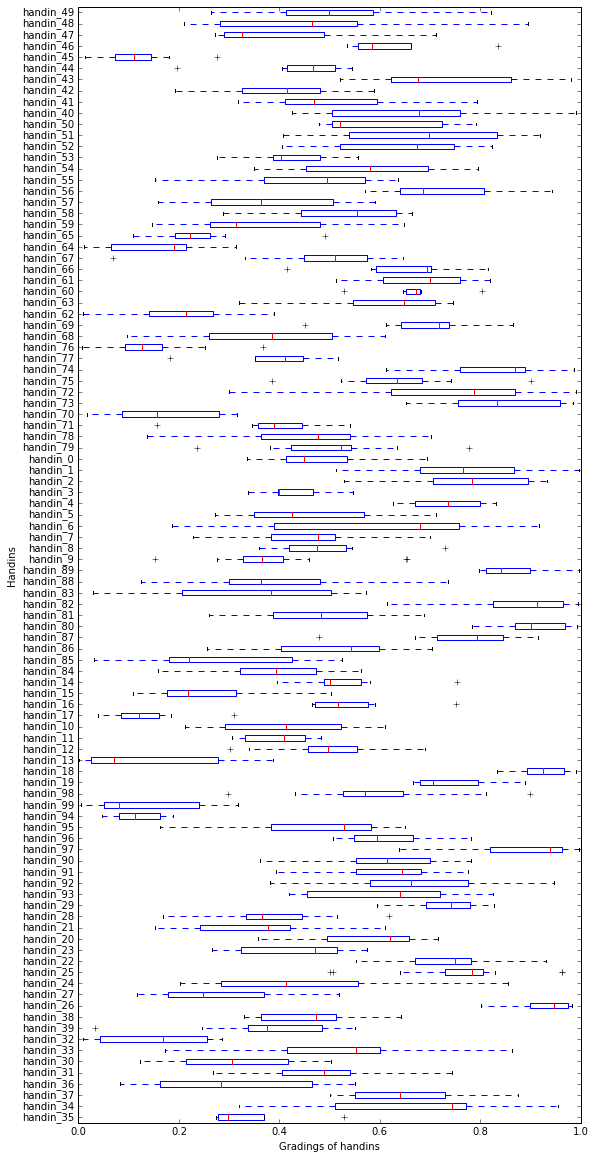

In [358]:
ax = plt.subplot(111)

values = list()
labels = list()

for title, h in assignment_data_true.handins.iteritems():
    v = map(lambda x: float(x),h.gradeings.values())
    values.append(v)
    labels.append(title)
    
plt.boxplot(values,0, vert=False, labels=labels)

box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*1.5, box.height*5])
plt.ylabel('Handins')
plt.xlabel('Gradings of handins')
plt.xlim(0,1)
plt.show()

Comparing this to the real data, we can see that the generated data have immitated the real data. So our model seems to be correct

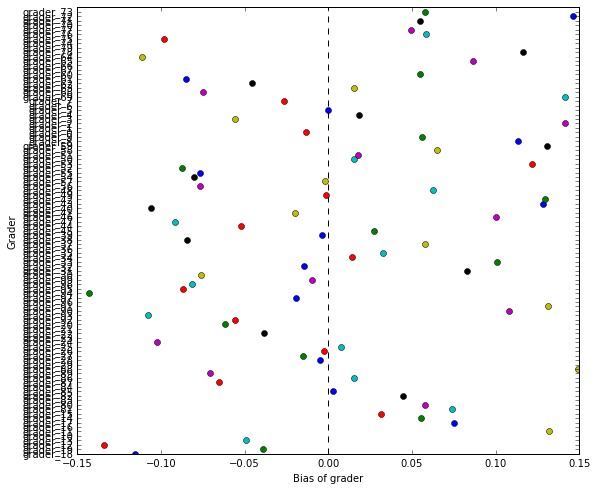

In [359]:
ax = plt.subplot(111)

values = list()
labels = list()

labels = list()

for y, g in enumerate(assignment_data_true.graders.itervalues()):
    x = g.bias_value
    plt.plot(x,y,'o')
    labels.append(g.name)

box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*1.5, box.height*2])
pos = range(0,len(labels))
plt.yticks(pos,labels)
plt.vlines(0, 0, len(labels), color="k", linestyles="--", lw=1)
plt.ylabel('Grader')
plt.xlabel('Bias of grader')
plt.xlim(-0.15,0.15)
plt.show()

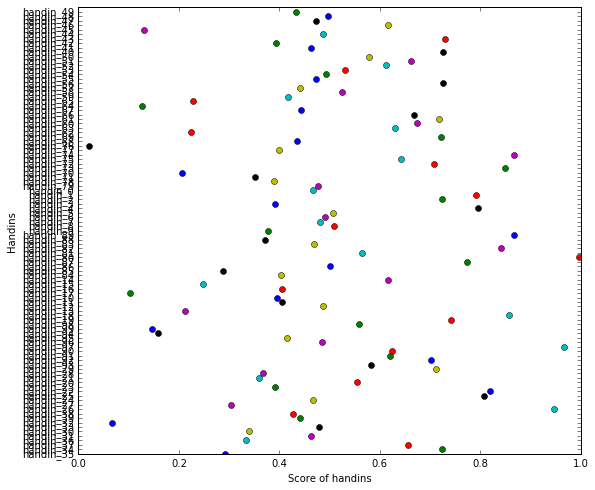

In [360]:
ax = plt.subplot(111)

values = list()
labels = list()

labels = list()

for y, h in enumerate(assignment_data_true.handins.itervalues()):
    x = h.true_val
    plt.plot(x,y,'o')
    labels.append(h.title)

box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width*1.5, box.height*2])
pos = range(0,len(labels))
plt.yticks(pos,labels)
plt.vlines(0, 0, len(labels), color="k", linestyles="--", lw=1)
plt.ylabel('Handins')
plt.xlabel('Score of handins')
plt.xlim(0,1)
plt.show()

## Back Again

Now that we have the generated data, We should be able to go the ohter way back and end up with the same data that where set to proudce the data

So I first define the model in Pymc

In [361]:
def handin_model(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        h_id = data[h].title
        scores = data[h].gradeings.items()
        
        N_G = len(scores)
        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.6,25)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=100)
        
        for g in range(0, N_G):
            (g_id,val) = scores[g]
            
            if g_id not in B:
                if g_id not in B_mu:
                    B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,750)
                if g_id not in B_tau:
                    B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=B_mu[g_id], tau=B_tau[g_id])
            O.append(pm.Normal('O_%(h)i_%(g)i' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=True, value=val))
        
            
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [ ]:
def execute_model(model):
    mcmc = pm.MCMC(model)
    mcmc.sample(5000,500)
    return mcmc

The model samples from distribution which can very much lead to different result. So we run the model 3 times in order to get a more telling result

In [ ]:
model_back = handin_model(assignment_data_true.handins.values())

In [ ]:
mcmc_back_1 = execute_model(model_back)

In [ ]:
mcmc_back_2 = execute_model(model_back)

In [ ]:
mcmc_back_3 = execute_model(model_back)

In [ ]:
mcmc_true = [mcmc_back_1,mcmc_back_2,mcmc_back_3]

In [ ]:
def find_bias(assignment,mcmc,f):
    bias_abs = list()
    for g in assignment.graders.keys():
        bias_mean = f(mcmc.trace('B_%s' % str(g))[:])
        bias_abs.append((bias_mean,g))
    return bias_abs

In [ ]:
def find_T(assignment,mcmc,f):
    bias = list()
    for h in assignment.handins.keys():
        bias_mean = f(mcmc.trace('T_%s' % str(h))[:])
        bias.append((bias_mean,h))
    return bias

In [ ]:
def plot_mean_var(ax,assignment_data,mcmc_handins,find,numpy_func):
    # find the mean bias of the two runs
    bias_abs_1 = find(assignment_data, mcmc_handins[0], numpy_func)
    bias_abs_2 = find(assignment_data, mcmc_handins[1], numpy_func)
    bias_abs_3 = find(assignment_data, mcmc_handins[2], numpy_func)

    # Generate dict of the found values in each run for each grader

    compared = defaultdict(list)
    collected = list()
    collected = bias_abs_1[:]
    collected.extend(bias_abs_2[:])
    collected.extend(bias_abs_3[:])

    for (value, _id) in collected:
        compared[_id].append(value)

    sorted_list = compared.items()
    sorted_list.sort(key=lambda x: np.mean(x[1][:]))

    labels = list()
    for (_id, value) in sorted_list:
        name = _id
        labels.append(name)

    values = map(lambda x: x[1], sorted_list)
    plt.boxplot(values,0, vert=False, labels=labels)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*2])
    plt.vlines(0, 0, 120, color="k", linestyles="--", lw=1)

    if find.func_name == "find_bias":
        plt.xlabel("%s value of the bias distributions of a grader" % numpy_func.func_name)
    else:
        plt.xlabel("%s value of the true score distributions of a grader" % numpy_func.func_name)

In [ ]:
ax = plt.subplot(191)
plot_mean_var(ax,assignment_data_true,mcmc_true,find_bias,np.mean)
ax = plt.subplot(199)
plot_mean_var(ax,assignment_data_true,mcmc_true,find_bias,np.var)
plt.show()

In [ ]:
ax = plt.subplot(191)
plot_mean_var(ax,assignment_data_true,mcmc_true,find_T,np.mean)
ax = plt.subplot(199)
plot_mean_var(ax,assignment_data_true,mcmc_true,find_T,np.var)
plt.show()

In [ ]:
def compare_to_generated(assignment_data,mcmc_handins,find):
    bias_abs_1 = find(assignment_data, mcmc_handins[0], np.mean)
    bias_abs_2 = find(assignment_data, mcmc_handins[1], np.mean)
    bias_abs_3 = find(assignment_data, mcmc_handins[2], np.mean)

    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = list()
    collected = bias_abs_1[:]
    collected.extend(bias_abs_2[:])
    collected.extend(bias_abs_3[:])

    for (value, _id) in collected:
        compared[_id].append(value)
    
    sorted_list = list()
    if find.func_name == "find_bias":
        for _id, g in assignment_data.graders.iteritems():
            sorted_list.append((_id,g.bias_value))
    else:
        for _id, h in assignment_data.handins.iteritems():
            sorted_list.append((_id,h.true_val))
    sorted_list.sort(key=lambda x: x[1])

    ax = plt.subplot(111)
    
    labels = list()
    true_values = list()
    score_values = list()
    mean_score_values = list()
    y = xrange(0,len(sorted_list))
    for (_id, value) in sorted_list:
        if find.func_name != "find_bias":
            mean_score = np.mean(assignment_data.handins[_id].gradeings.values())
            mean_score_values.append(mean_score)
        score_values.append(np.mean(compared[_id]))
        true_values.append(value)
        labels.append(_id)
    
    if find.func_name == "find_bias":
        plt.plot(score_values,y,'or',label="Pymc found bias",alpha=0.65)
        plt.plot(true_values,y,'ob',label="True bias",alpha=0.65)
    else:
        plt.plot(score_values,y,'or',label="Pymc found handin score",alpha=0.65)
        plt.plot(mean_score_values,y,'og',label="Mean of handin scores",alpha=0.65)
        plt.plot(true_values,y,'ob',label="True handin score",alpha=0.65)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*2])
    plt.yticks(xrange(0,len(sorted_list)),labels)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.99))
    if find.func_name == "find_bias":
        plt.xlabel("True graders bias compared to the found bias through pymc")
        plt.ylabel("Graders")
    else:
        plt.xlabel("True handin score compared to the found handin score through pymc")
        plt.ylabel("Handins")

In [ ]:
compare_to_generated(assignment_data_true,mcmc_true,find_bias)

In [ ]:
compare_to_generated(assignment_data_true,mcmc_true,find_T)